In [1]:
import numpy as np
print("numpy version - {}".format(np.__version__))
import pandas as pd
print("pandas version - {}".format(pd.__version__))
import matplotlib
print("matplotlib version - {}".format(matplotlib.__version__))
import matplotlib.pyplot as plt
import seaborn as sns
print("seaborn version - {}".format(sns.__version__))
import sklearn
print("sklearn version - {}".format(sklearn.__version__))
%matplotlib inline
import xgboost
print("xgboost version - {}".format(xgboost.__version__))
from xgboost import XGBRegressor
from xgboost import plot_importance

numpy version - 1.17.4
pandas version - 0.25.3
matplotlib version - 3.1.2
seaborn version - 0.9.0
sklearn version - 0.21.3
xgboost version - 0.90


In [2]:
import datetime
import random
import time
import sys
import gc
import pickle
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# import data

In [3]:
data_path = '../data/competitive-data-science-predict-future-sales'

In [4]:
!ls ../data/competitive-data-science-predict-future-sales

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [5]:
item_cat = pd.read_csv(data_path + '/item_categories.csv')
items = pd.read_csv(data_path + '/items.csv')
shops = pd.read_csv(data_path + '/shops.csv')
train = pd.read_csv(data_path + '/sales_train.csv')
test = pd.read_csv(data_path + '/test.csv')
sample_sub = pd.read_csv(data_path + '/sample_submission.csv')

# functions

In [6]:
def eda(data):
    print("----------Top-5- Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)

def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);
    
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)
    
def unresanable_data(data):
    print("Min Value\n{}".format(data.min()))
    print("Max Value\n{}".format(data.max()))
    print("Average Value\n{}".format(data.mean()))
    print("Center Point of Data\n{}".format(data.median()))

# train data

In [7]:
eda(train)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        flo

{dtype('O'), dtype('int64'), dtype('float64')}


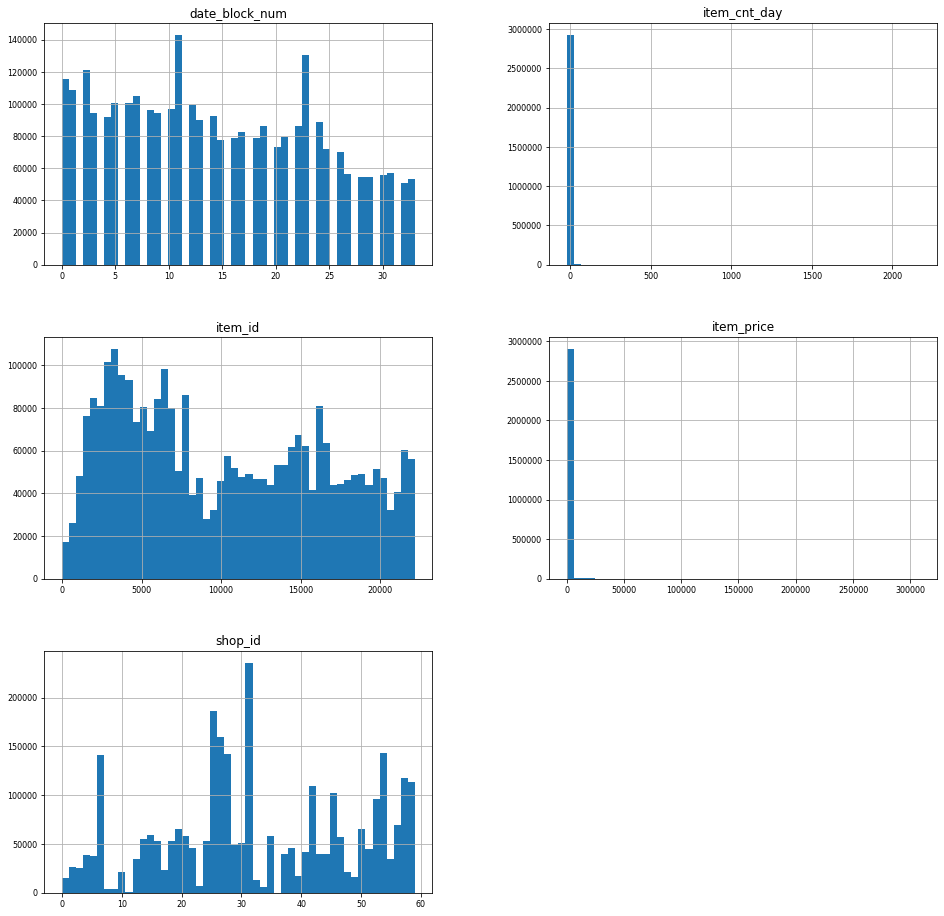

In [8]:
graph_insight(train)

# drop duplicate data

In [9]:
subset = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']
drop_duplicate(train, subset=subset)

Before drop shape: (2935849, 6)
After drop shape: (2935825, 6)
Total Duplicate: 24


# test data

In [10]:
eda(test)

----------Top-5- Record----------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB
None
-----------Data Types-----------
ID         int64
shop_id    int64
item_id    int64
dtype: object
----------Missing value-----------
ID         0
shop_id    0
item_id    0
dtype: int64
----------Null value-----------
ID         0
shop_id    0
item_id    0
dtype: int64
----------Shape of Data----------
(214200, 3)


{dtype('int64')}


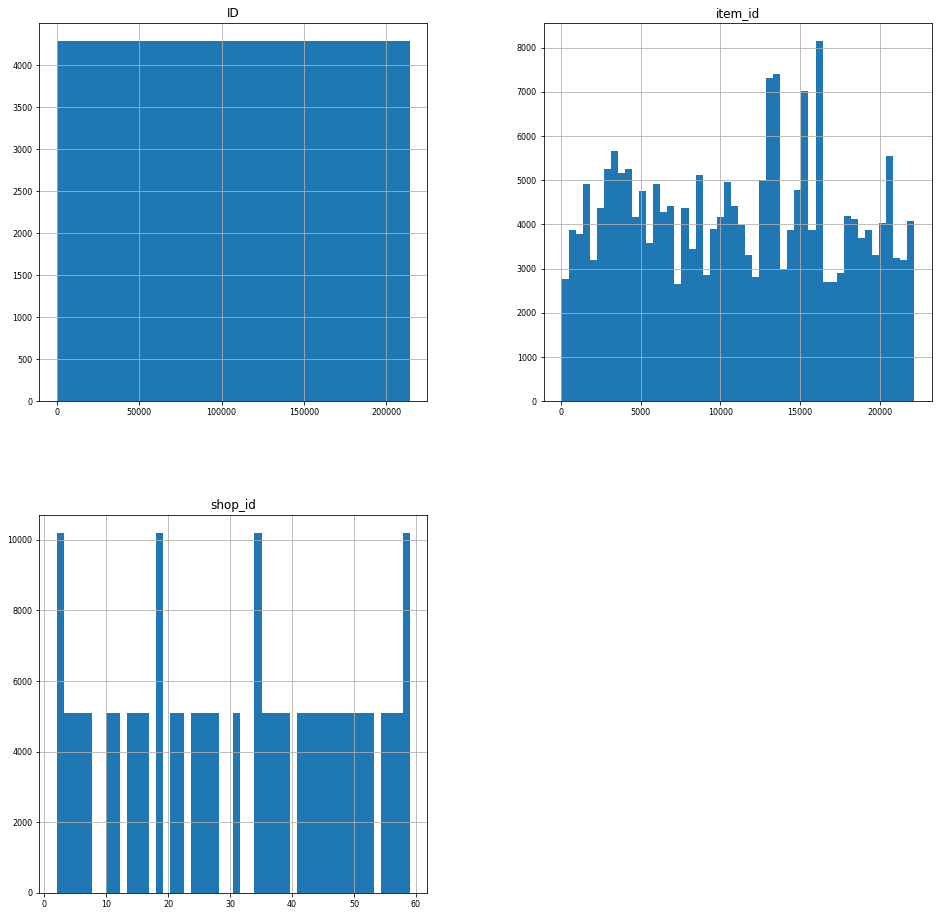

In [11]:
graph_insight(test)

# items data

In [12]:
eda(items)

----------Top-5- Record----------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
-----------Data Types-----------
item_name           object
item_id              int64
item_category_id     int64
dtype:

{dtype('O'), dtype('int64')}


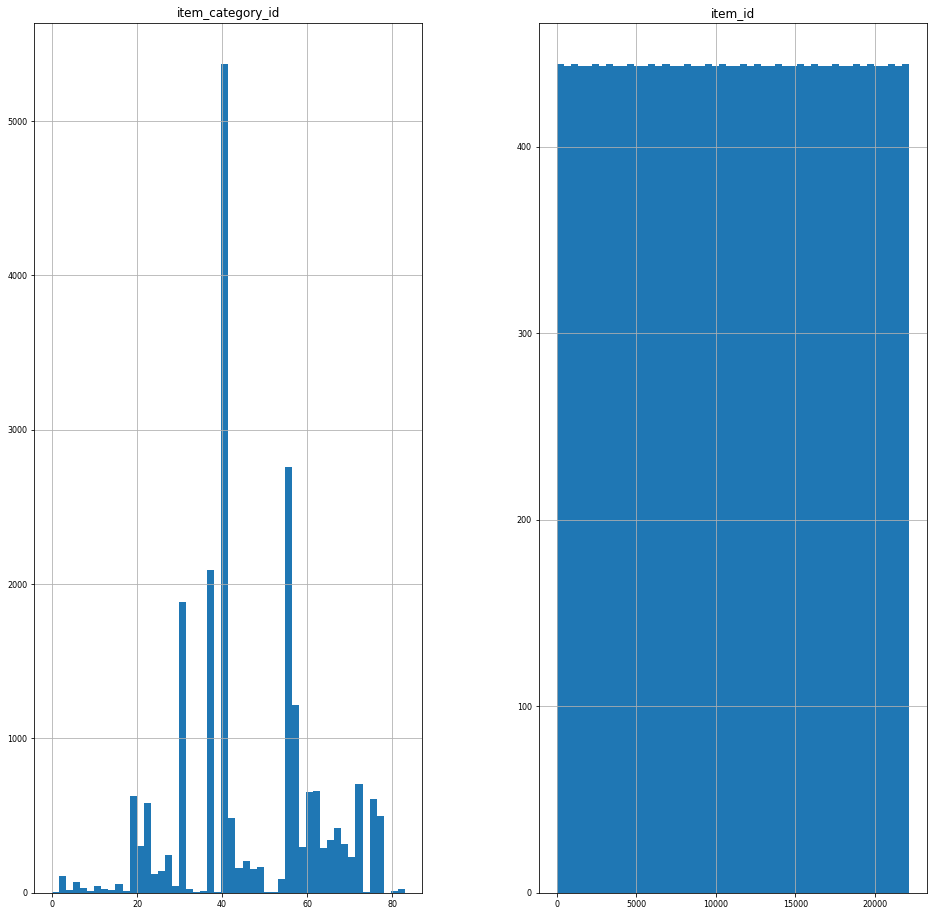

In [13]:
graph_insight(items)

# category data

In [14]:
eda(item_cat)

----------Top-5- Record----------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
-----------Data Types-----------
item_category_name    object
item_category_id       int64
dtype: object
----------Missing value-----------
item_category_name    0
item_category_id      0
dtype: int64
----------Null value-----------
item_category_name    0
item_category_id      0
dtype: int64
----------Shape of Data----------
(84, 2)


In [15]:
#graph_insight(item_cat)

# shops data

In [16]:
eda(shops)

----------Top-5- Record----------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
-----------Data Types-----------
shop_name    object
shop_id       int64
dtype: object
----------Missing value-----------
shop_name    0
shop_id      0
dtype: int64
----------Null value-----------
shop_name    0
shop_id      0
dtype: int64
----------Shape of Data----------
(60, 2)


In [17]:
#graph_insight(shops)

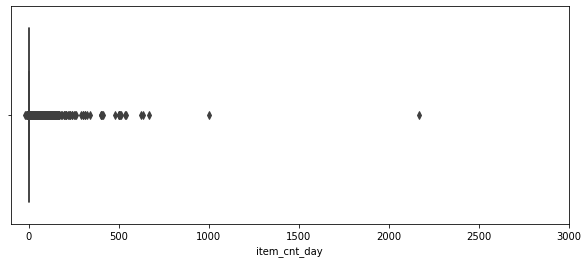

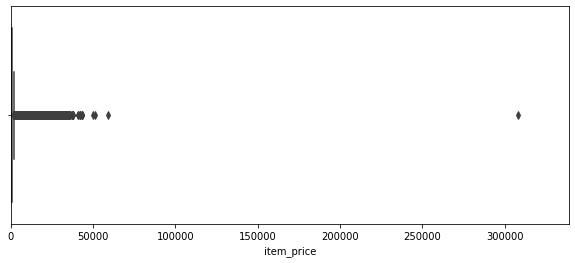

In [18]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

# remove discharge samples

In [19]:
print('before train shape:', train.shape)
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]
print('after train shape:', train.shape)

before train shape: (2935825, 6)
after train shape: (2935823, 6)


In [20]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484675,15.05.2013,4,32,2973,-1.0,1.0


In [21]:
item_price_median = train[train.item_price >= 0].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = item_price_median

In [22]:
train[train.item_cnt_day < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934219,26.10.2015,33,25,3917,449.0,-1.0
2934438,18.10.2015,33,25,4896,6398.0,-1.0
2935239,05.10.2015,33,25,10039,249.0,-1.0
2935619,16.10.2015,33,25,7893,2990.0,-1.0


In [23]:
train[train.shop_id == 25]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935820,10.10.2015,33,25,7409,299.00,1.0
2935821,09.10.2015,33,25,7460,299.00,1.0
2935822,14.10.2015,33,25,7459,349.00,1.0
2935823,22.10.2015,33,25,7440,299.00,1.0


In [24]:
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = 0 

In [25]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935823e+06,2.935823e+06,2.935823e+06,2.935823e+06,2.935823e+06
mean,1.456992e+01,3.300172e+01,1.019721e+04,8.907516e+02,1.244473e+00
std,9.422981e+00,1.622698e+01,6.324300e+03,1.720497e+03,2.290930e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03


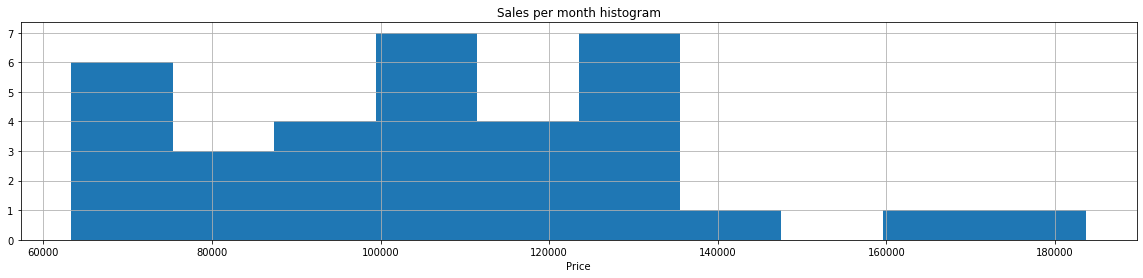

In [26]:
train.groupby('date_block_num').sum()['item_cnt_day'].hist(figsize=(20, 4));
plt.title('Sales per month histogram');
plt.xlabel('Price');

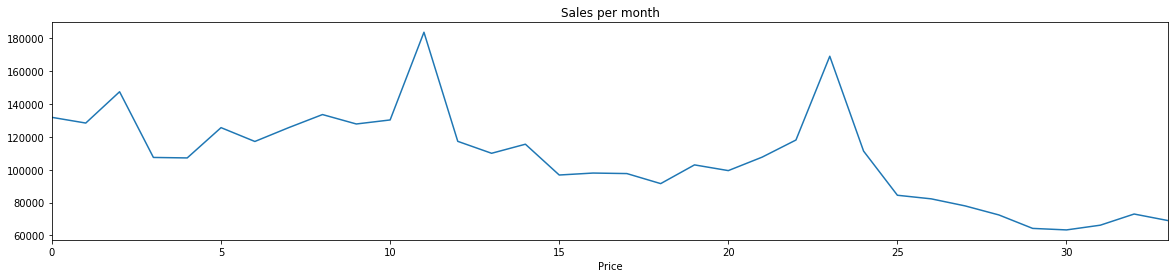

In [27]:
plt.figure(figsize=(20, 4));
sns.tsplot(train.groupby('date_block_num').sum()['item_cnt_day']);
plt.title('Sales per month');
plt.xlabel('Price');

In [28]:
unresanable_data(train['item_price'])

Min Value
0.07
Max Value
59200.0
Average Value
890.7516248270123
Center Point of Data
399.0


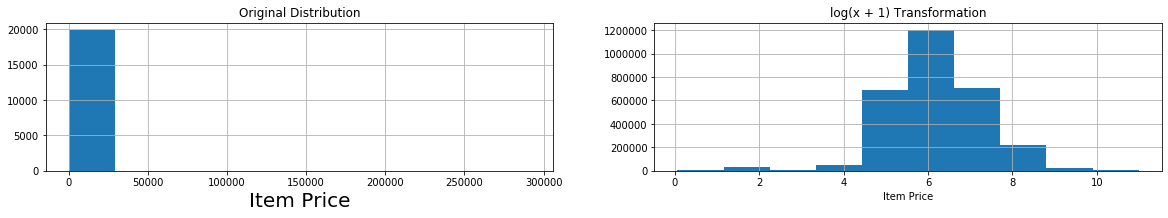

In [29]:
count_price = train.item_price.value_counts().sort_index(ascending=False);
plt.subplot(221);
count_price.hist(figsize=(20, 6));
plt.xlabel('Item Price', fontsize=20);
plt.title('Original Distribution');

plt.subplot(222);
train.item_price.map(np.log1p).hist(figsize=(20, 6));
plt.xlabel('Item Price');
plt.title('log(x + 1) Transformation');
train.loc[:, 'item_price'] = train.item_price.map(np.log1p);

In [30]:
unresanable_data(train['date_block_num'])

Min Value
0
Max Value
33
Average Value
14.569916170014336
Center Point of Data
14.0


Text(0.5, 1.0, 'Original Distiribution')

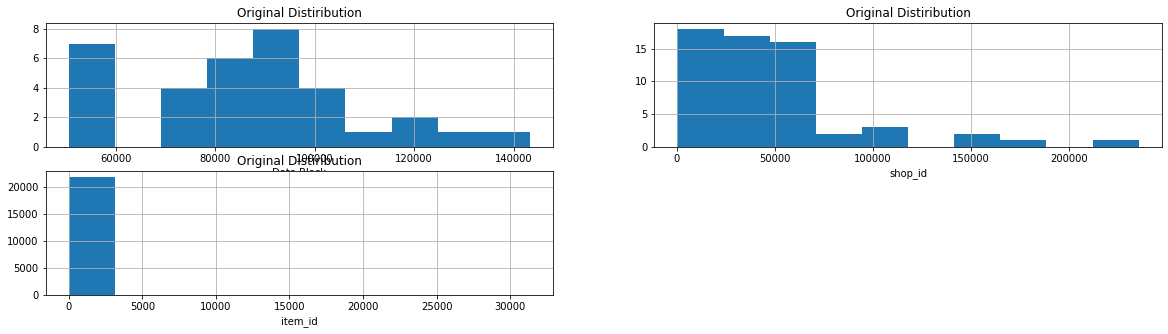

In [31]:
count_price = train.date_block_num.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,5))
plt.xlabel('Date Block');
plt.title('Original Distiribution')

count_price = train.shop_id.value_counts().sort_index(ascending=False)
plt.subplot(222)
count_price.hist(figsize=(20,5))
plt.xlabel('shop_id');
plt.title('Original Distiribution')

count_price = train.item_id.value_counts().sort_index(ascending=False)
plt.subplot(223)
count_price.hist(figsize=(20,5))
plt.xlabel('item_id');
plt.title('Original Distiribution')

### Map the items

In [32]:
item_cat.item_category_name.unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

In [33]:
l_cat = list(item_cat.item_category_name)

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


item_cat['cats'] = l_cat
item_cat.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [34]:
item_cat.cats.unique()

array(['PC - Гарнитуры/Наушники', 'Access', 'Билеты (Цифра)',
       'Доставка товара', 'Consoles', 'Consoles Games',
       'Игры - Аксессуары для игр', 'phone games', 'CD games', 'Card',
       'Movie', 'Books', 'Music', 'Gifts', 'Soft', 'Служебные',
       'Служебные - Билеты', 'Чистые носители (шпиль)',
       'Чистые носители (штучные)', 'Элементы питания'], dtype=object)

### Convert Date Column data type from object to Date

In [35]:
train['date'] = pd.to_datetime(train.date, format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,6.907755,1.0
1,2013-01-03,0,25,2552,6.802395,1.0
2,2013-01-05,0,25,2552,6.802395,0.0
3,2013-01-06,0,25,2554,7.444278,1.0
4,2013-01-15,0,25,2555,7.003065,1.0


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935823 entries, 0 to 2935824
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB


In [37]:
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [38]:
p_df

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22154    1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22155    0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22155    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  
        22164    2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[424123 rows x 34 columns]

In [39]:
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

In [40]:
train_cleaned_df

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424119,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424120,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
424121,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [41]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [42]:
item_cat.head(5)

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [43]:
item_to_cat_df = items.merge(item_cat[['item_category_id', 'cats']], \
                            how="inner", on="item_category_id")[['item_id', 'cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

In [44]:
train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

In [45]:
train_cleaned_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie


In [46]:
from sklearn import preprocessing

In [47]:
number = preprocessing.LabelEncoder()

In [48]:
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)

In [49]:
train_cleaned_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [50]:
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,cats,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# model building

In [51]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

0.992370670092263


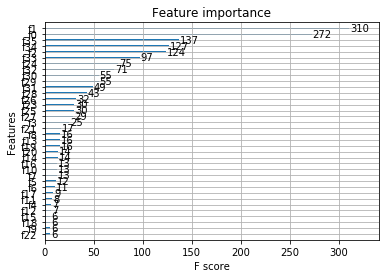

In [52]:
xgb.plot_importance(bst)

In [53]:
apply_df = test
apply_df['shop_id'] = apply_df.shop_id.astype('str')
apply_df['item_id'] = apply_df.item_id.astype('str')

apply_df = test.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Move to one month front

In [54]:
apply_df.columns

Index([     'ID', 'shop_id', 'item_id',    'cats',         0,         1,
               2,         3,         4,         5,         6,         7,
               8,         9,        10,        11,        12,        13,
              14,        15,        16,        17,        18,        19,
              20,        21,        22,        23,        24,        25,
              26,        27,        28,        29,        30,        31,
              32,        33],
      dtype='object')

In [55]:
d = dict(zip(apply_df.columns[4:],list(np.array(list(apply_df.columns[4:])) - 1)))

apply_df  = apply_df.rename(d, axis = 1)

In [56]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)].values))

# Normalize prediction to [0-20]

In [57]:
preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID, 'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.292479
std,61834.358168,0.739469
min,0.000000,0.000000
25%,53549.750000,0.132060
50%,107099.500000,0.163924
75%,160649.250000,0.222277
max,214199.000000,20.000000


In [61]:
sub_df.to_csv('Submission_Predict_Sales.csv',index=False)

In [62]:
!ls

 predict-sales.ipynb		 Submission_Predict_Sales.csv
'Submission_Predict Sales.csv'


In [63]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f Submission_Predict_Sales.csv -m "submission 1"

100%|██████████| 5.32M/5.32M [00:04<00:00, 1.29MB/s]
Successfully submitted to Predict Future Sales